In [1]:
import glob
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import os
import yt
from yt.utilities.physical_constants import G
from yt.visualization.color_maps import yt_colormaps

from yt.extensions.p2p.data_plotter import DataPlotter
from yt.extensions.p2p.model_profiles import \
    find_peaks, \
    load_model_profiles
from yt.extensions.p2p.stars import get_star_data

In [2]:
pyplot.rcParams['figure.figsize'] = (15, 9)
pyplot.rcParams['font.size'] = 20

In [3]:
yt.mylog.setLevel(40)

## Choose a star

In [4]:
star_id = 334267081  ### first star
# star_id = 334267082  ### irradiated 1x, no heating, metal-free
# star_id = 334267083  ### irradiated 2x, heated 1x, metal-enriched (original target halo)
# star_id = 334267086  ### irradiated 2x, no heating, metal-free
# star_id = 334267090  ### irradiated 3x, heated 2x, metal-free
# star_id = 334267093  ### irradiated 4x, heated 2x, metal-free
# star_id = 334267099  ### irradiated 6x, minimal signs of heating, metal-free
# star_id = 334267102  ### irradiated 7x, heated 1x, metal-free
# star_id = 334267111  ### (target halo) irradiated 8x, multiple heatings, metal-enriched, some centering issues

In [5]:
star_data = get_star_data("star_hosts.yaml")
my_star = star_data[star_id]
creation_time = my_star["creation_time"]

## Load all profiles

In [6]:
filename = os.path.join("star_cubes", f"star_{star_id}_radius.h5")
pds = yt.load(filename)
profile_data = pds.data

## Plot a bunch of profiles

Change `x_field` below to one of the other values to plot profiles vs. enclosed gas or total mass.

In [7]:
# x_field = 'radius'
x_field = 'gas_mass_enclosed'
# x_field = 'total_mass_enclosed'

plots = (
    ('gas_density', x_field),
    ('dm_density', x_field),
    ('temperature', x_field),
    ('entropy', x_field),
    ('pressure', x_field),
    ('hydrostatic_pressure', x_field),
    ('H2_fraction', x_field),
    ('metallicity', x_field),
    ('gas_mass_enclosed', 'radius'),
    ('baryon_fraction', x_field),
    ('mbe_ratio', x_field),
    ('timescale_ratio', x_field),
    ('turbulent_velocity', x_field),
    ('turbulent_mach_number', x_field),
)

labels = {
    'radius': 'r [pc]',
    'gas_mass_enclosed': 'M$_{gas,enc}$ [Msun]',
    'total_mass_enclosed': 'M$_{tot,enc}$ [Msun]',
    'gas_density': '$\\rho_{b}\ [g/cm^{3}]$',
    'dm_density': '$\\rho_{dm}\ [g/cm^{3}]$',
    'temperature': 'T [K]',
    'entropy': 'entropy [erg cm$^{2}$]',
    'pressure': 'p [dyne/cm$^{2}$]',
    'hydrostatic_pressure': 'p / p$_{eq}$',
    'H2_fraction': 'f$_{H2}$',
    'metallicity': 'Z [Zsun]',
    'baryon_fraction': 'M$_{gas,enc}$ / M$_{tot,enc}$',
    'mbe_ratio': 'M$_{gas,enc}$ / M$_{BE}$',
    'timescale_ratio': 't$_{cs}$ / t$_{ff}$',
    'turbulent_velocity': 'v$_{turb}$ [km/s]',
    'turbulent_mach_number': 'M$_{turb}$',
}

Plotting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:02<00:00, 255.02it/s]


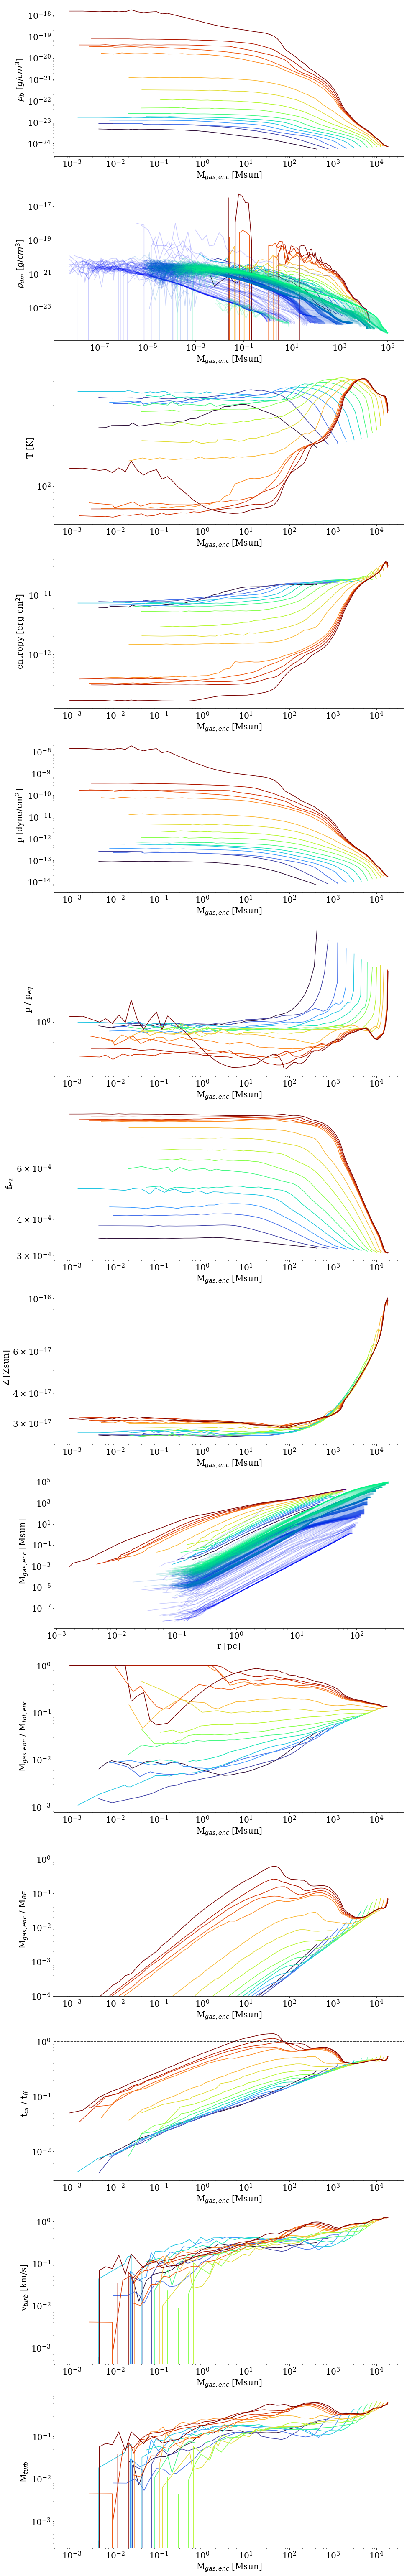

In [8]:
### Bonnor-Ebert Mass constant
a = 1.67
b = (225 / (32 * np.sqrt(5 * np.pi))) * a**-1.5

n_plots = len(plots)

times = profile_data["data", "time"].to("Myr")
ibefore = (times < creation_time).sum()
iafter = times.size - ibefore

plotter = DataPlotter(plots, labels)
pbar = yt.get_pbar("Plotting", times.size)

for i, current_time in enumerate(times):
    pbar.update(i+1)

    before = current_time < creation_time

    used = profile_data["data", "used"][i].d.astype(bool)
    radius_bins = profile_data["data", "radius"]
    lrb = np.log10(radius_bins)
    radius = np.power(10, (lrb[:-1] + lrb[1:]) / 2)[used] * radius_bins.units
    dr = np.diff(radius_bins)[used]

    m_tot_enc = profile_data["data", "total_mass_enclosed"][i, used].to("Msun")
    m_gas_enc = profile_data["data", "gas_mass_enclosed"][i, used].to("Msun")
    m_dm_enc = profile_data["data", "dark_matter_mass_enclosed"][i, used].to("Msun")

    rho_v = profile_data["data", "gas_density_volume_weighted"][i, used]
    rho_dm = profile_data["data", "dark_matter_density_volume_weighted"][i, used]

    plot_data = {
        "radius": radius,
        "gas_mass_enclosed": m_gas_enc,
        "total_mass_enclosed": m_tot_enc,
        "dm_density": rho_dm,
    }

    if before:
        rho = profile_data["data", "density"][i, used]
        T = profile_data["data", "temperature"][i, used]
        H2 = profile_data["data", "H2_p0_fraction"][i, used]
        Z = profile_data["data", "metallicity3"][i, used].to("Zsun")
        p = profile_data["data", "pressure"][i, used]
        entropy = profile_data["data", "entropy"][i, used].to("erg*cm**2")
        
        cs = profile_data["data", "sound_speed"][i, used]
        v_turb = profile_data["data", "turbulent_velocity"][i, used]
        cs_eff = np.sqrt(cs**2 + v_turb**2)

        m_BE = (b * (cs**4 / G**1.5) * p**-0.5).to("Msun")
        m_rat = m_gas_enc / m_BE

        # t_ff = profile_data["data", "total_dynamical_time"][i, used].to("Myr") / np.sqrt(2)
        t_ff = profile_data["data", "dynamical_time"][i, used].to("Myr") / np.sqrt(2)
        t_cool = profile_data["data", "cooling_time"][i, used].to("Myr")
        t_cs = (2 * radius / cs_eff).to("Myr")
        t_rat = t_cs / t_ff
        # t_rat = t_cool / t_ff

        # include dark matter and baryon mass
        # dp = (G * m_tot_enc * rho * dr / radius**2)
        # p_eq = dp[::-1].cumsum()[::-1]

        # include dark matter mass only
        # dp_dm = (G * m_dm_enc * rho * dr / radius**2)
        # p_eq_dm = dp_dm[::-1].cumsum()[::-1].in_cgs()

        p_hyd = profile_data["data", "hydrostatic_pressure"][i, used]

        plot_data.update({
            "gas_density": rho,
            "temperature": T,
            "entropy": entropy,
            "pressure": p,
            "hydrostatic_pressure": (p/p_hyd).to(""),
            "H2_fraction": H2,
            "metallicity": Z,
            "mbe_ratio": m_rat,
            "timescale_ratio": t_rat,
            "baryon_fraction": (m_gas_enc/m_tot_enc),
            "turbulent_velocity": v_turb.to("km/s"),
            "turbulent_mach_number": (v_turb/cs).to("")
        })

    if before:
        color = pyplot.cm.turbo(float(i/(ibefore-1)))
        alpha = 1
    else:
        color = pyplot.cm.winter(float(i-ibefore)/(iafter-1))
        alpha = 0.2
    plotter.plot_data(plot_data, color=color, alpha=alpha)

pbar.finish()

plotter.plot_axes()
plotter.axes["mbe_ratio"].set_ylim(1e-4, 3)
plotter.axes["mbe_ratio"].axhline(y=1, color="black", linestyle="--")
plotter.axes["timescale_ratio"].axhline(y=1, color="black", linestyle="--")
pyplot.show()

## Plot peaks in Bonnor-Ebert mass

In [ ]:
ds = yt.load(os.path.join("star_cubes", f"star_{star_id}_mass.h5"))

time_index = -1

rebin_field = ("data", "gas_mass_enclosed")
data_field = ("data", "bonnor_ebert_ratio")
i_peaks  = find_peaks(ds, rebin_field, data_field, time_index)

plot = True
if plot:
    bin_data = ds.data[rebin_field][time_index]
    peak_data = ds.data[data_field][time_index]
    peak_used = peak_data > 0

    pyplot.loglog(bin_data[peak_used], peak_data[peak_used])
    pyplot.scatter(bin_data[i_peaks], peak_data[i_peaks])
    pyplot.xlabel("M$_{gas, enc}$ [Msun]")
    pyplot.ylabel("peak field")
    pyplot.show()